# **Dokumentacja końcowa**
## **Autorzy:** Mateusz Szczęsny, Małgorzata Kubiak
### **Temat projektu:** Nienadzorowana detekcja anomalii na podstawie niepodobieństwa do sąsiadów

## **Pełna treść zadania:**
Nienadzorowana detekcja anomalii na podstawie niepodobieństwa do sąsiadów z możliwością użycia dowolnej miary niepodobieństwa. Porównanie z nienadzorowaną detekcją anomalii za pomocą algorytmów klasyfikacji jednoklasowej dostępnych w środowisku R lub Python.


## **Opis implementacji**
Tutaj jakis opis

## Uzyte bilbioteki

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import test_functions
from our_knn import KNNAnomalyDetector
from sklearn.preprocessing import StandardScaler
import plotting_functions
from sklearn.model_selection import StratifiedKFold
import numba as nb
from sklearn.metrics import precision_recall_curve, auc, f1_score

from pyod.models.knn import KNN
import sklearn.neighbors
import sklearn.ensemble

#%matplotlib ipympl

%load_ext autoreload
%autoreload 2

## **Opis i wizualizacje zbiorów danych**

Do testów wybrane zostały 2 zbiory danych znalezione na stronie internetowej Outlier Detection DataSets (ODDS). Są to zbiory "thyroid" i "cardio". 

Zbiór "thyroid" (tarczyca) składa się z 3772 przykładów. Każdy przykład ma 6 ciągłych atrybutów. Klasą traktowaną jako anomalia jest nadczynność tarczycy i stanowi około 2.5% przykładów. 

Zbiór "cardio" złożony jest z danych pomiarowych czynności serca. Zbiór zawiera 1831 przykładów. Każdy przykład ma 21 atrybutów. Klasa traktowana jako anomalia to patologiczna praca serca. Anomalie stanowią około 9.6% zbioru danych. 

### Wczytywanie i wizualizacja zbioru "thyroid"

In [2]:
# load thyroid dataset
# labels are 0 1 where 1 is anomaly. Feature 1 is an integer. Other features are continuos
thyroid_data = pd.read_csv('thyroid.csv') 

thyroid_data = thyroid_data.iloc[:1000] # shrink dataset for test purposes

thyroid_data_columns = thyroid_data.columns
thyroid_features = thyroid_data[thyroid_data_columns[:6]]
thyroid_labels = thyroid_data[thyroid_data_columns[6]]

# change labels so 1 in no anomalyand -1 is anomaly (sklearn anomaly detecion convention)
thyroid_labels[thyroid_labels == 1] = -1
thyroid_labels[thyroid_labels == 0] = 1

### Korelacja atrybutów w zbiorze danych

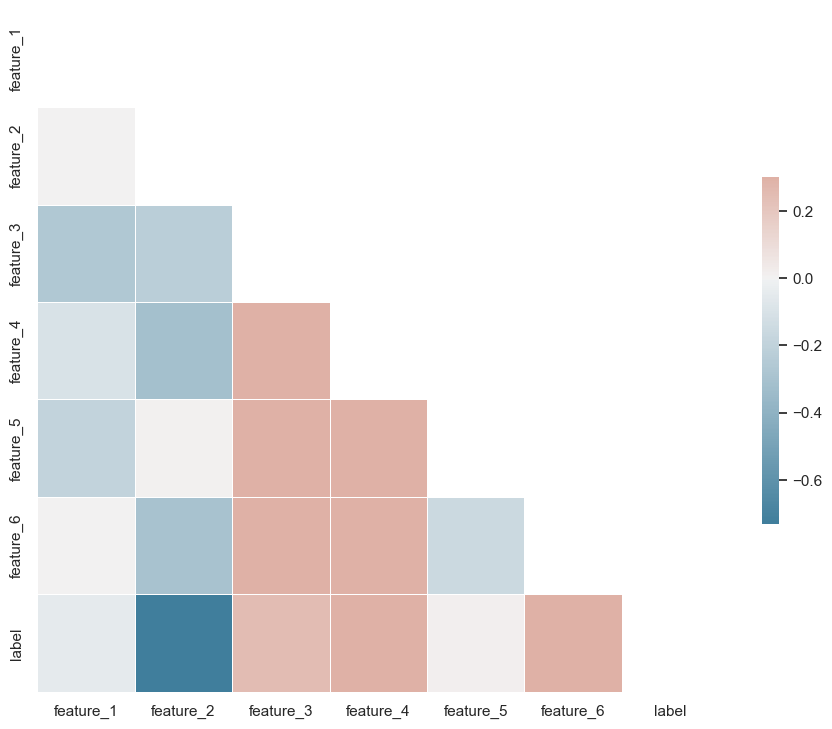

In [3]:
plotting_functions.plot_corr(thyroid_data)

Widzimy że "feautre_2" ma dość mocną korelacje z klasą. Pozatym Atrybuty mają dość niskie korelacje między sobą. 

### Wizualizacja rozkładu atrybutów zbioru "thyroid"

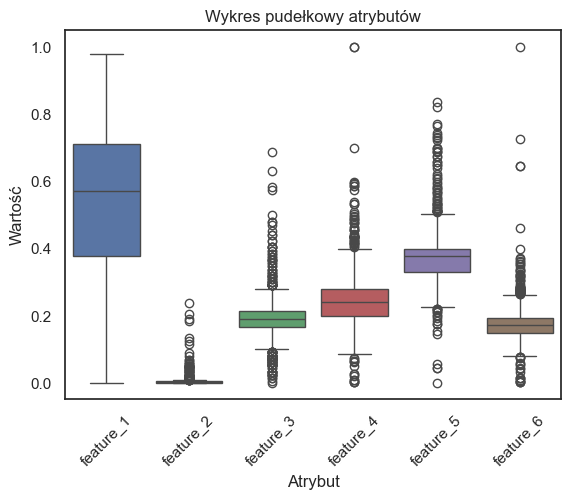

In [4]:
plotting_functions.plot_feature_dist(thyroid_features)

Na wykresie widzimy że poza atrybutem nr. 1 (feature_1) atrybuty posiadają sporo wartości które można uznać za odstające, czyli wychodzące o ponad 1.5 odległości miedzy pierwszym a trzecim kwartylem od bliższego im brzegu pudełka. 

### Wizualizacja relacji 3 głównych komponetnów zbioru "thyroid"

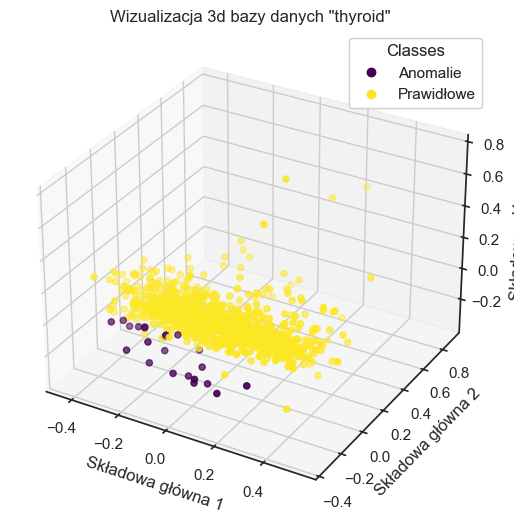

In [5]:
# 3D PCA thyroid dataset visualisation
plotting_functions.plot_pca_3d(thyroid_features, thyroid_labels, "Wizualizacja 3d bazy danych \"thyroid\"")

Powyższa wizualizacja przedstawia zbiór danych po rozkładzie na 3 główne składowe. Przy takim rozładzie widać że klasa anomalii znajduje się niedaleko ale jednak poza głównym skupiskiem punktów. 

## Wczytywanie i wizualizacja zbioru "shuttle"

In [6]:
# shuttle dataset loading. The dataset cointains 9 features and 7 classes. Class '1' makes up 80% of the dataset. For ourlier detection class '4'is discarted and the other classes are combined. 
shuttle_colnames=['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'label']
shuttle_data = pd.read_csv('shuttle.tst', sep=' ', header=None, names=shuttle_colnames)

shuttle_data = shuttle_data[shuttle_data['label'] != 4] # remove class '4'

shuttle_data = shuttle_data.iloc[:1000] # shrink dataset for test purposes

shuttle_features = shuttle_data[shuttle_colnames[:9]]
shuttle_labels = shuttle_data[shuttle_colnames[9]]

shuttle_labels[shuttle_labels == 1] = 1
shuttle_labels[(shuttle_labels == 2) | (shuttle_labels == 3) | (shuttle_labels == 5) | (shuttle_labels == 6) | (shuttle_labels == 7)] = -1


In [7]:
# add standard scaler because of large feature value range differences
shuttle_scaler = StandardScaler()
shuttle_feature_columns = shuttle_features.columns
shuttle_features = pd.DataFrame(shuttle_scaler.fit_transform(shuttle_features), columns=shuttle_feature_columns)

### Wizualizacja korelacji atrybutów zbioru "shuttle"

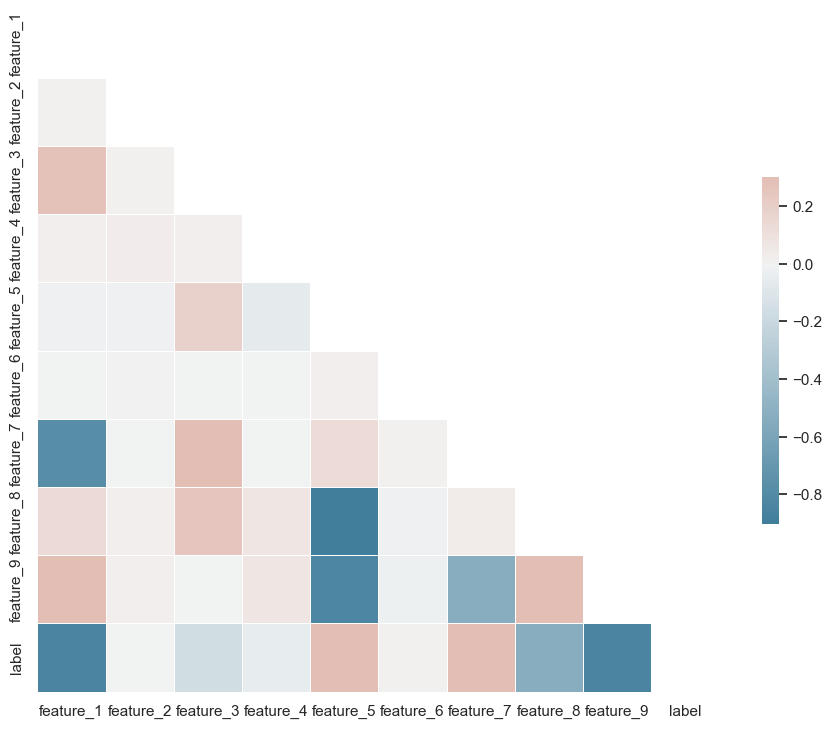

In [8]:
plotting_functions.plot_corr(shuttle_data)

W zbiorze "shuttle" widzimy ujemną korelacje między feature_1 i fature_9 a klasą przykładu. Widzimy też ujemne korelacje między atrybutami o numerach 1 i 7, 5 i 8 oraz 5 i 9. Reszta korelacji jest dużo mniejsza. 

### Wizyalizacja rozkładu wartości atrybutów zbioru "shuttle"

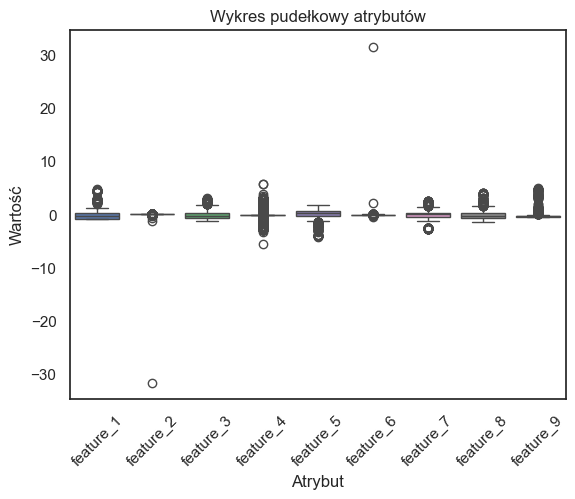

In [9]:
plotting_functions.plot_feature_dist(shuttle_features)

Jeszcze bardziej niż w przypadku zbioru "thyroid", na zbiorze "shuttle" widzimy że wszystkie atrybuty maja bardzo mocno odstające od więszkości przykłady pod względem wartości atrybutów. 

### Wizualizcja 3d głównych składowych zbioru "shuttle"

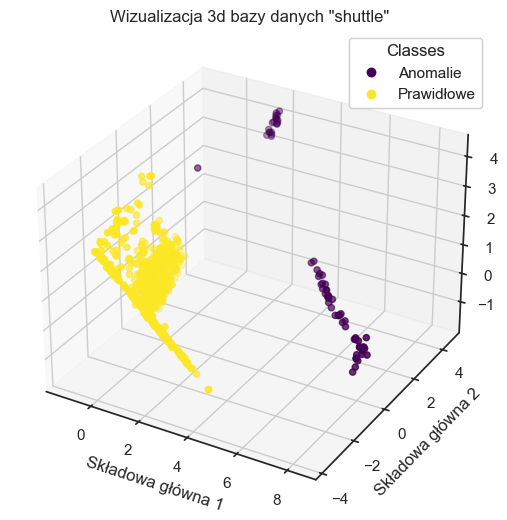

In [10]:
# 3D PCA thyroid dataset visualization

# remove some extreme values for visualization (this is used insead of crop/zoom)
PCA_shuttle_features = shuttle_features[shuttle_features < 20].dropna()
PCA_shuttle_labels = shuttle_labels.iloc[PCA_shuttle_features.index]

plotting_functions.plot_pca_3d(PCA_shuttle_features, PCA_shuttle_labels, "Wizualizacja 3d bazy danych \"shuttle\"")

Przy rozkładzie na 3 główne składowe, widać że anomaplie znajdują się poza głównym skupiskiem danych.

# Testy dla różnych metryk odległości i liczby sąsiadów

Definicja 3 testowanych miar odległości. Miary które wybraliśmy to miara euklidesowa czyli pierwiastek z różnicy kwadratów po wszystkich wymiarach, odległość manhattan czyli różnica po wszystkich wymiarach oraz odległość minkowski czyli .....

In [11]:
@nb.jit(nopython=True)  
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

@nb.jit(nopython=True)  
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

@nb.jit(nopython=True)  
def minkowski_distance_p3(x1, x2, p=3):
    return np.sum(np.abs(x1 - x2)**p)**(1/p)


### Testy dla zbioru "thyroid"

In [12]:
# test parameters
distances = [euclidean_distance, manhattan_distance, minkowski_distance_p3]
n_neighbors = [1, 5, 10, 50, 500]

In [13]:
result_df = test_functions.test_loop(thyroid_features, thyroid_labels, n_neighbors, distances, [None])

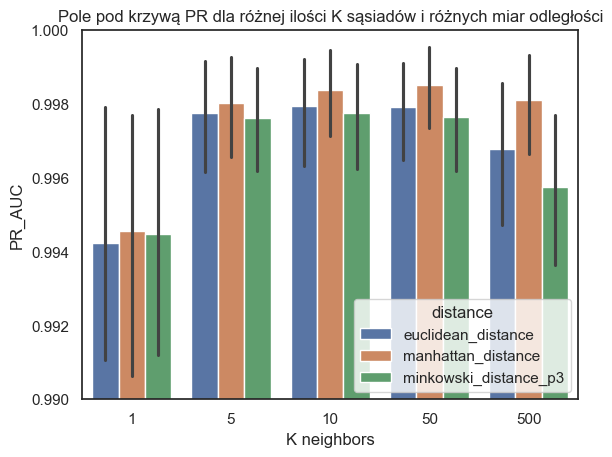

In [14]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="K neighbors", y="PR_AUC", hue="distance", ax=ax)
ax.set_ylim(0.99, 1)
plt.title("Pole pod krzywą PR dla różnej ilości K sąsiadów i różnych miar odległości")
plt.show()

Co ciekawe pole powierzchni pod krzywą PR spada dla coraz większej liczby sąsiadów. 

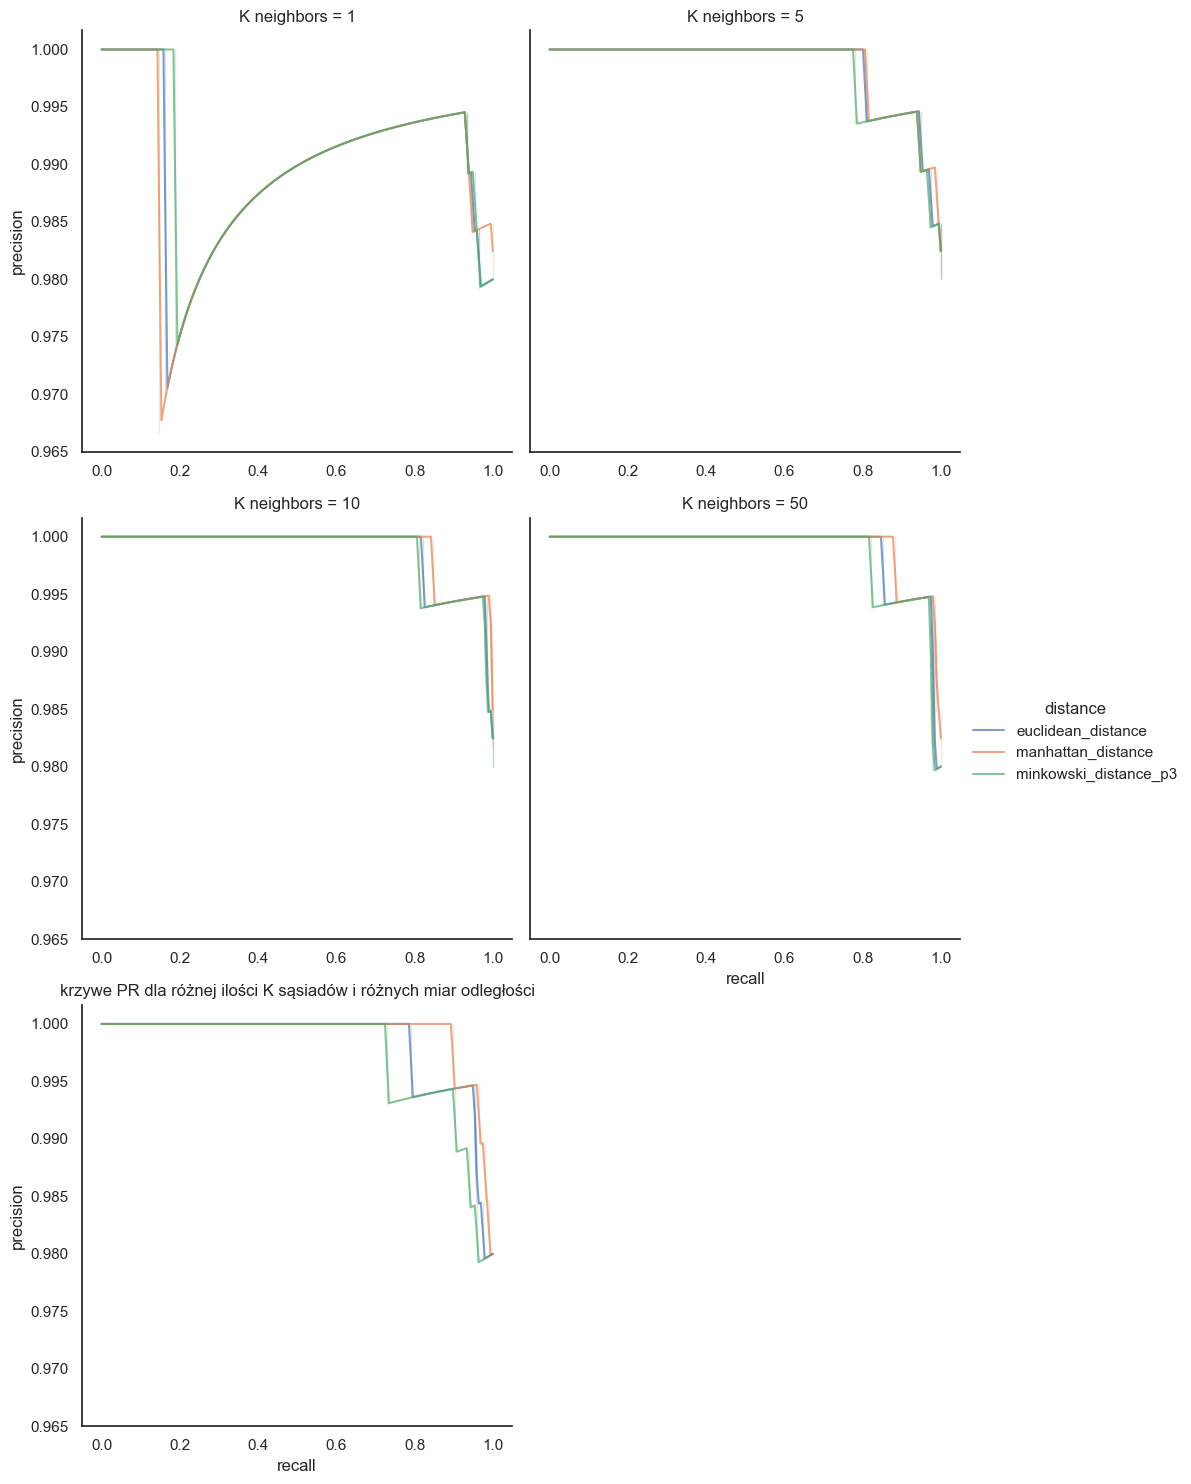

In [15]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
#pr_df = pr_df[pr_df["K neighbors"] == 10]

pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="distance", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)
plt.title("krzywe PR dla różnej ilości K sąsiadów i różnych miar odległości")
plt.show()

Krzywe PR dla różnych miar odległości są bardzo bliskie siebie,.......

### Testy dla zbioru "shuttle"

In [16]:
result_df = test_functions.test_loop(shuttle_features, shuttle_labels, n_neighbors, distances, [None])

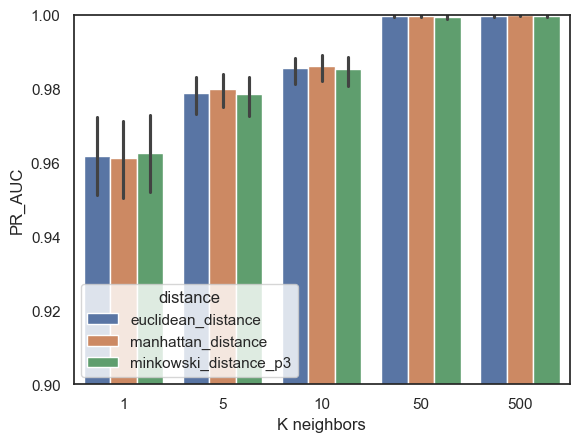

In [17]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="K neighbors", y="PR_AUC", hue="distance", ax=ax)
ax.set_ylim(0.9, 1)
plt.show()

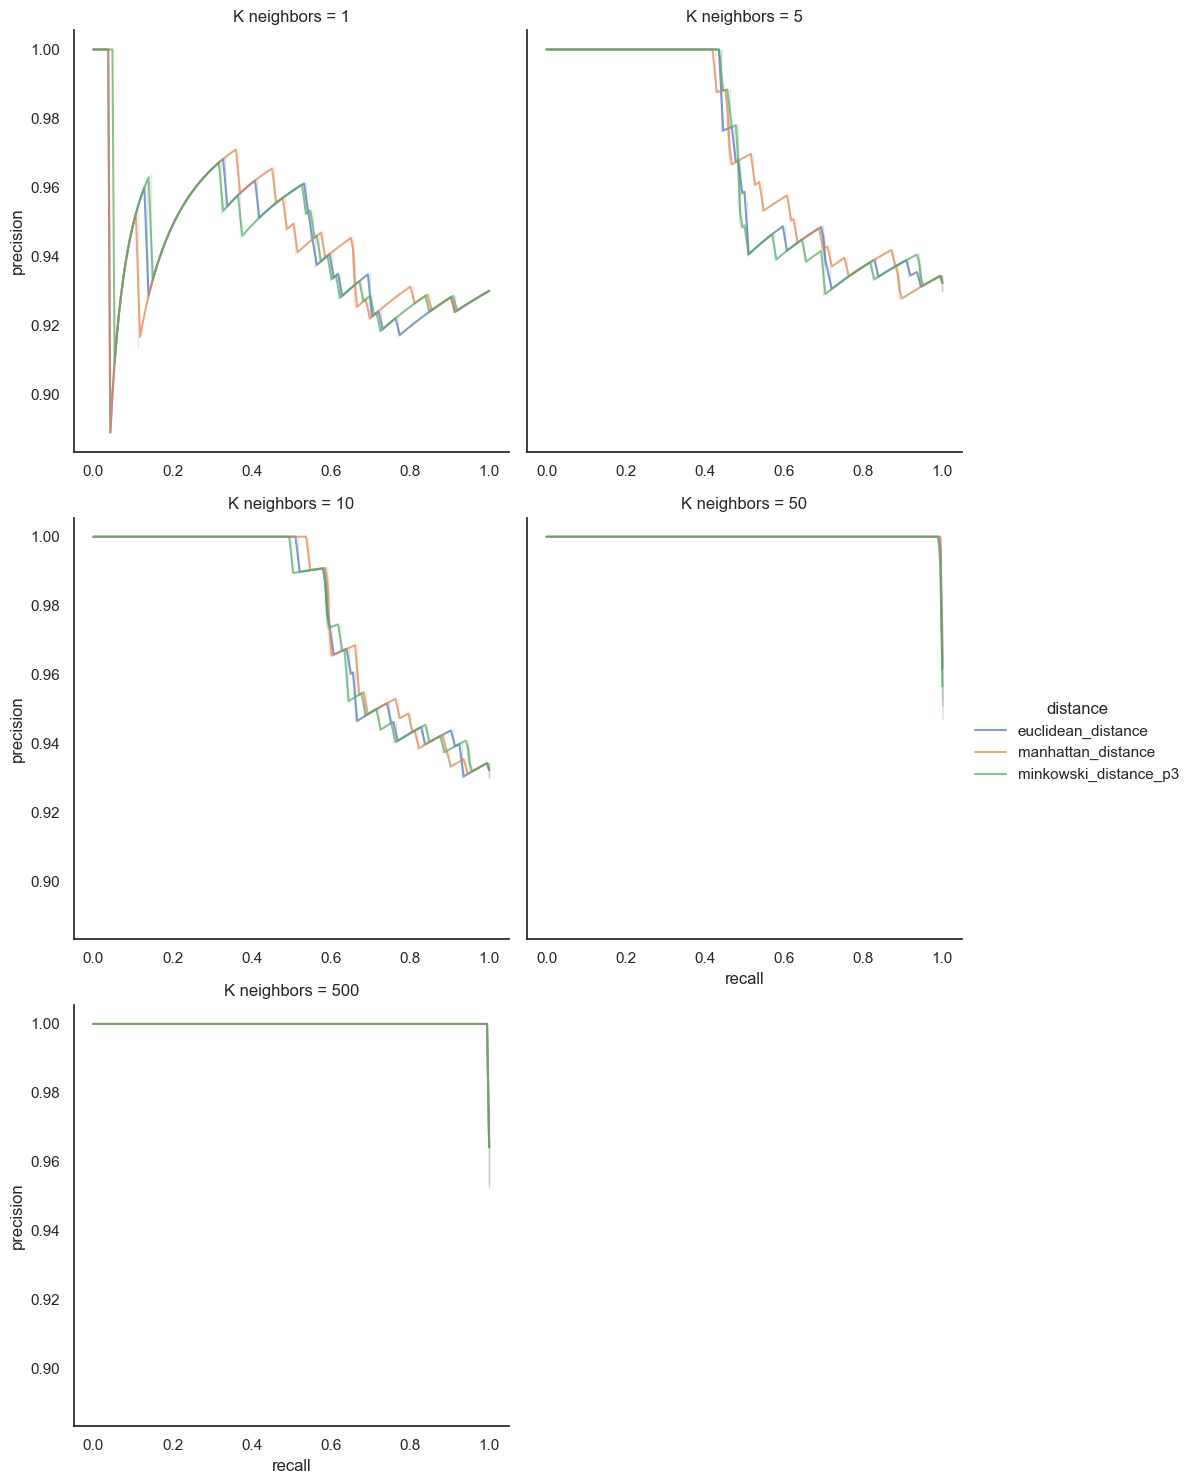

In [18]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
#pr_df = pr_df[pr_df["K neighbors"] == 10]

pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="distance", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)

# Testy dla średniej odległości od wszystkich sąsiadów i odległości od k-tego sąsiada

### testy dla zboiru "thyroid"

In [19]:
def distance_from_nth(distances, X, k):
    kth_nearest_neighbor = np.argsort(distances, axis=1)[:, k-1:k]
    return distances[np.arange(len(X))[:, None], kth_nearest_neighbor]

def distance_avg(distances, X, k):
    return np.mean(distances, axis=1) 

def density(distances, X, k, fitted_detector=None):
    nearest_neighbors = np.argsort(distances, axis=1)[:, :k]
    if fitted_detector is None:
        fitted_detector = KNNAnomalyDetector(k=k)
        fitted_detector.fit(nearest_neighbors)
    neighbor_scores = fitted_detector.predict(nearest_neighbors)
    neighbor_scores = nearest_neighbors.reshape((-1, k)) # ensure 2d
    return np.mean(neighbor_scores, axis=1)

In [20]:
# test parameters
score_funcs = [distance_from_nth, distance_avg, density]
n_neighbors = [1, 5, 10, 50]

In [21]:
result_df = test_functions.test_loop(thyroid_features, thyroid_labels, n_neighbors, [None], score_funcs)

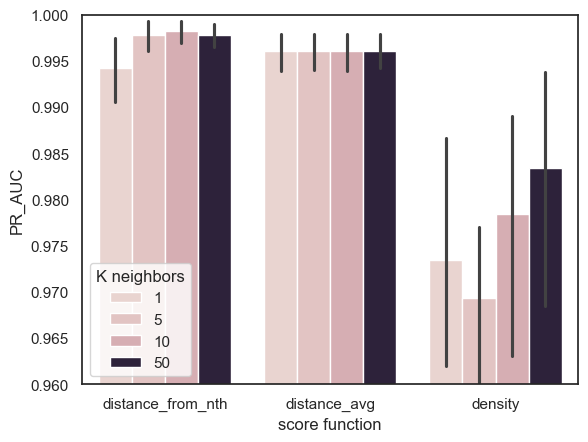

In [22]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="score function", y="PR_AUC", hue="K neighbors", ax=ax)
ax.set_ylim(0.96, 1)
plt.show()

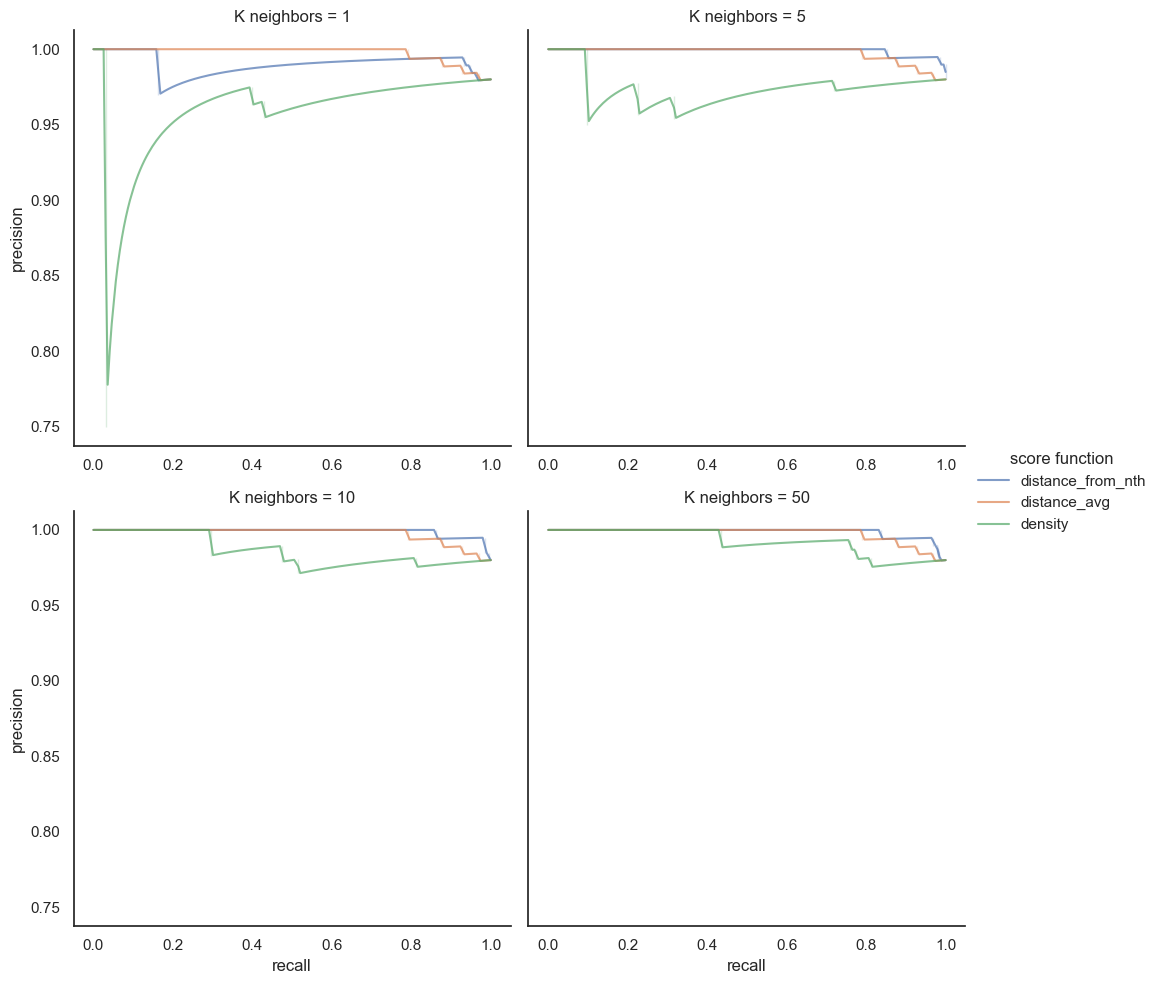

In [23]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
#pr_df = pr_df[pr_df["K neighbors"] == 10]

pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="score function", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)

### testy dla zbioru shuttle

In [24]:
result_df = test_functions.test_loop(shuttle_features, shuttle_labels, n_neighbors, [None], score_funcs)

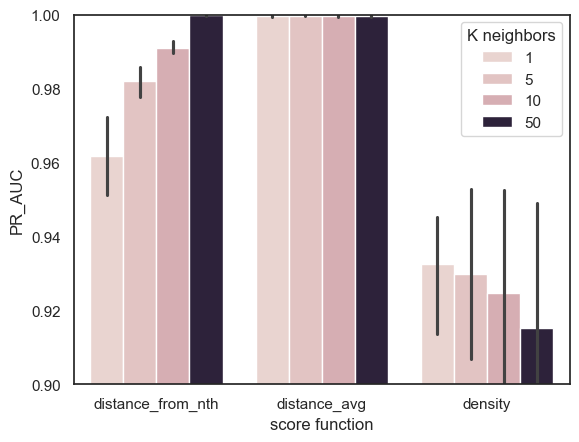

In [25]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="score function", y="PR_AUC", hue="K neighbors", ax=ax)
ax.set_ylim(0.90, 1)
plt.show()

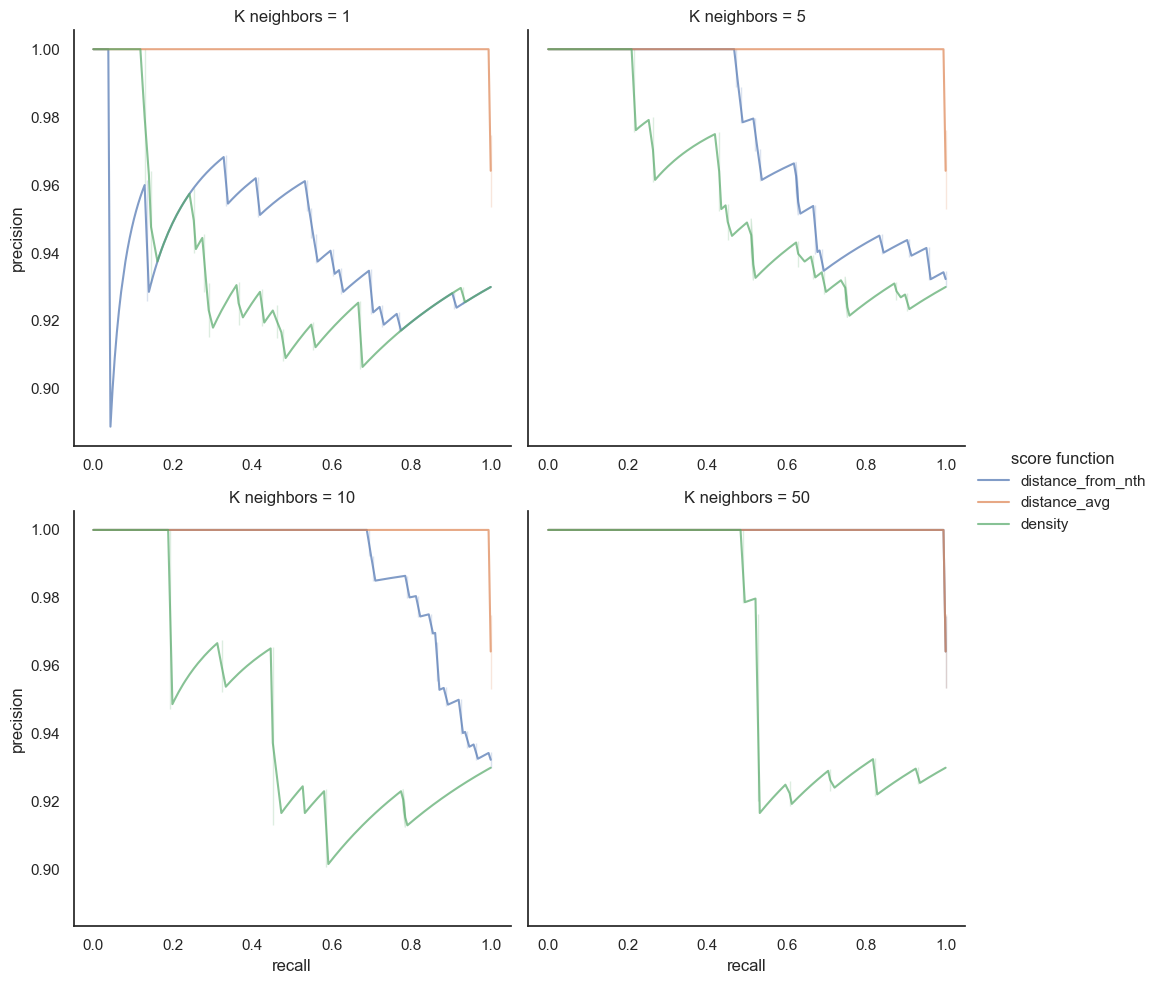

In [26]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
#pr_df = pr_df[pr_df["K neighbors"] == 10]

pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="score function", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)

# Testy dla treningu bez anomalii oraz traningu z anomaliami

Dla zbioru "thyroid"

In [27]:
filters_inliers = [True, False]
n_neighbors = [5]
thresholds = [50, 95, 100]

In [28]:
result_df = test_functions.test_loop(thyroid_features, thyroid_labels, 
                                     n_neighbors, [None], [None], 
                                     thresholds=thresholds, 
                                     filter_inliers=filters_inliers)

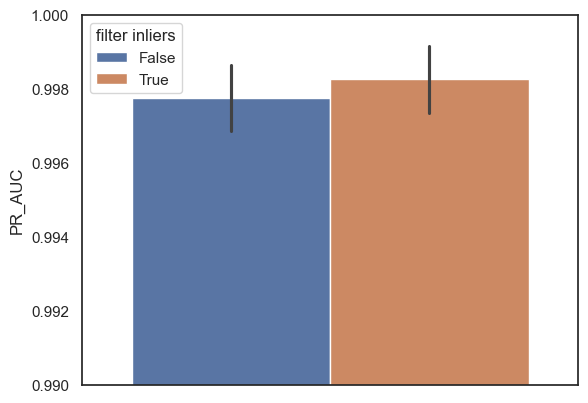

In [29]:
fig, ax = plt.subplots()
sns.barplot(result_df, y="PR_AUC", hue="filter inliers")
ax.set_ylim(0.99, 1)
plt.show()

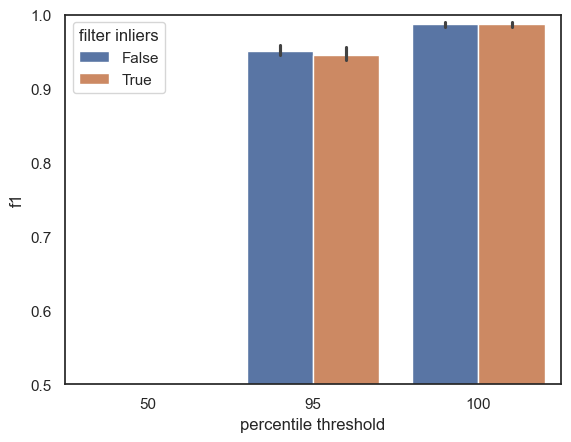

In [30]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="percentile threshold", y="f1", hue="filter inliers")
ax.set_ylim(0.5, 1)
plt.show()

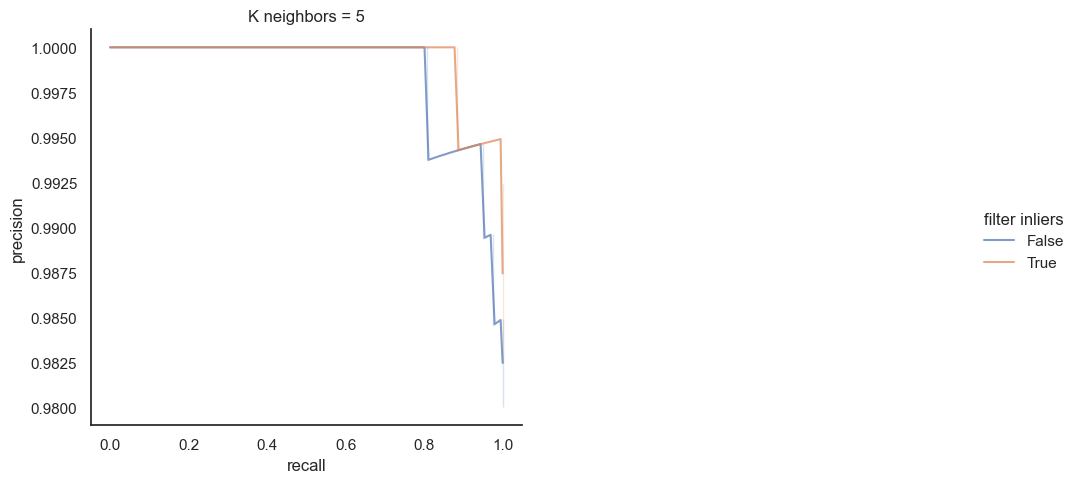

In [33]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
pr_df = pr_df[pr_df["percentile threshold"] == 100]
pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="filter inliers", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)

Dla zbioru "shuttle"

In [34]:
result_df = test_functions.test_loop(shuttle_features, shuttle_labels, 
                                     n_neighbors, [None], [None], 
                                     thresholds=thresholds, 
                                     filter_inliers=filters_inliers)

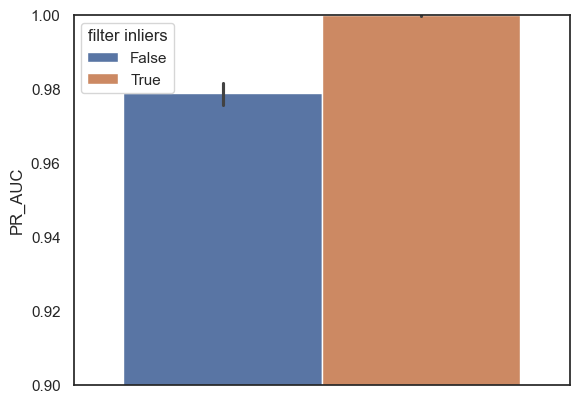

In [38]:
fig, ax = plt.subplots()
sns.barplot(result_df, y="PR_AUC", hue="filter inliers")
ax.set_ylim(0.90, 1)
plt.show()

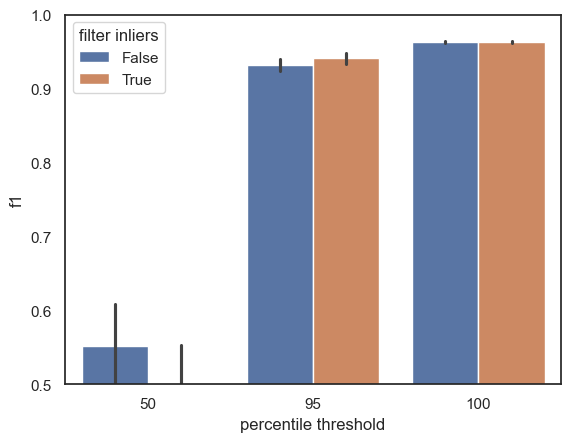

In [36]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="percentile threshold", y="f1", hue="filter inliers")
ax.set_ylim(0.5, 1)
plt.show()

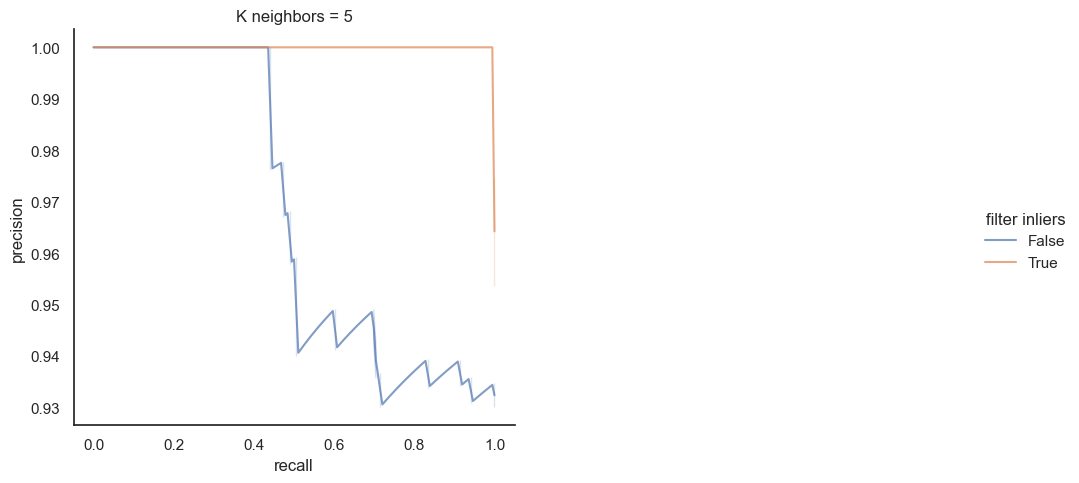

In [40]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
pr_df = pr_df[pr_df["percentile threshold"] == 100]
pr_df = pr_df.explode(['recall', 'precision'])



sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="filter inliers", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)

## Porównanie do implementacji z biblioteki sklearn i innych detektorów anomalii

### Porownanie do bibliotecznego KNN

In [41]:
k_list = [1, 5, 10, 50]
X = np.array(thyroid_features)
y = np.array(thyroid_labels)

In [42]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_arr = []
precision_arr = []
recall_arr = []
PR_AUC_arr = []
k_neighbors_arr = []
cv_arr = []
detector_arr = []


for k in k_list:
    detector1 = KNNAnomalyDetector(k=k)
    detector2 = KNN(contamination=0.05, n_neighbors=k, method='mean', n_jobs=-1)

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        detector1.fit(X_train)
        detector2.fit(X_train)
        predictions1 = detector1.predict(X_test)
        predictions2 = detector2.predict(X_test)
        predictions2 = predictions2 * -2 + 1

        scores = detector1.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, -scores)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, predictions1, average='binary')

        f1_arr.append(f1)
        precision_arr.append(precision)
        recall_arr.append(recall)
        PR_AUC_arr.append(pr_auc)
        k_neighbors_arr.append(k)
        cv_arr.append(i)
        detector_arr.append("Our implementation")

        scores = detector2.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, -scores)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, predictions2, average='binary')

        f1_arr.append(f1)
        precision_arr.append(precision)
        recall_arr.append(recall)
        PR_AUC_arr.append(pr_auc)
        k_neighbors_arr.append(k)
        cv_arr.append(i)
        detector_arr.append("PYOD implementation")
            
result_df = pd.DataFrame({"f1":f1_arr, "precision":precision_arr, "recall":recall_arr, 
                            "PR_AUC":PR_AUC_arr,  
                            "K neighbors":k_neighbors_arr, "CV":cv_arr, 
                            "detector": detector_arr})

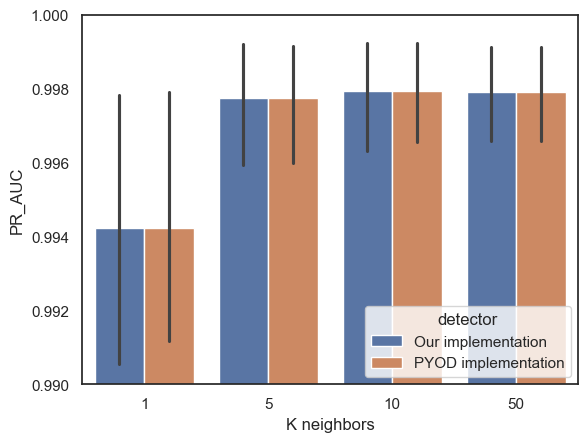

In [43]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="K neighbors", y="PR_AUC", hue="detector")
ax.set_ylim(0.99, 1)
plt.show()

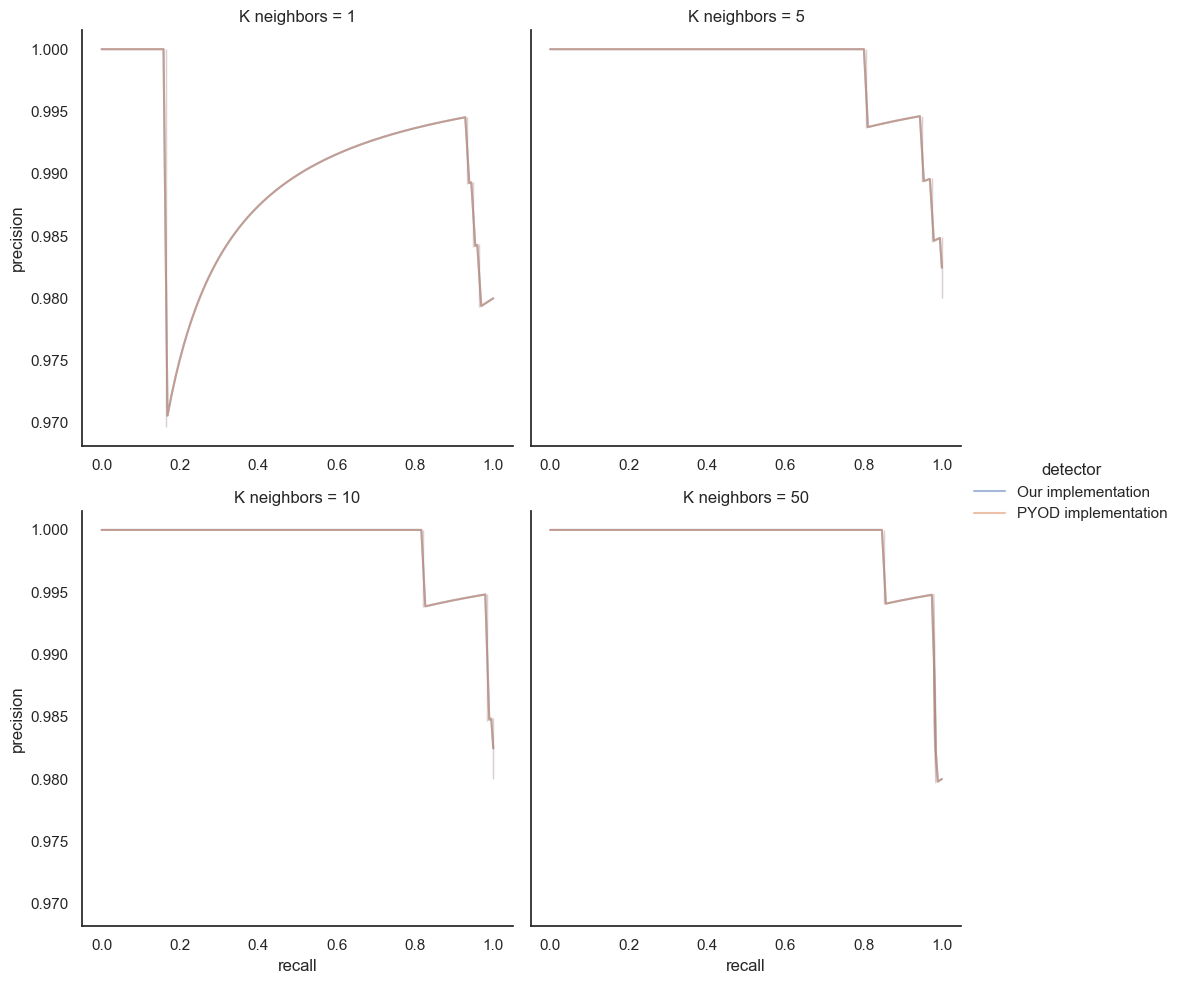

In [44]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="detector", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.5
)

To samo dla shuttle

In [45]:
X = np.array(shuttle_features)
y = np.array(shuttle_labels)

In [46]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_arr = []
precision_arr = []
recall_arr = []
PR_AUC_arr = []
k_neighbors_arr = []
cv_arr = []
detector_arr = []


for k in k_list:
    detector1 = KNNAnomalyDetector(k=k)
    detector2 = KNN(contamination=0.05, n_neighbors=k, method='mean', n_jobs=-1)

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        detector1.fit(X_train)
        detector2.fit(X_train)
        predictions1 = detector1.predict(X_test)
        predictions2 = detector2.predict(X_test)
        predictions2 = predictions2 * -2 + 1

        scores = detector1.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, -scores)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, predictions1, average='binary')

        f1_arr.append(f1)
        precision_arr.append(precision)
        recall_arr.append(recall)
        PR_AUC_arr.append(pr_auc)
        k_neighbors_arr.append(k)
        cv_arr.append(i)
        detector_arr.append("Our implementation")

        scores = detector2.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, -scores)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, predictions2, average='binary')

        f1_arr.append(f1)
        precision_arr.append(precision)
        recall_arr.append(recall)
        PR_AUC_arr.append(pr_auc)
        k_neighbors_arr.append(k)
        cv_arr.append(i)
        detector_arr.append("PYOD implementation")
            
result_df = pd.DataFrame({"f1":f1_arr, "precision":precision_arr, "recall":recall_arr, 
                            "PR_AUC":PR_AUC_arr,  
                            "K neighbors":k_neighbors_arr, "CV":cv_arr, 
                            "detector": detector_arr})

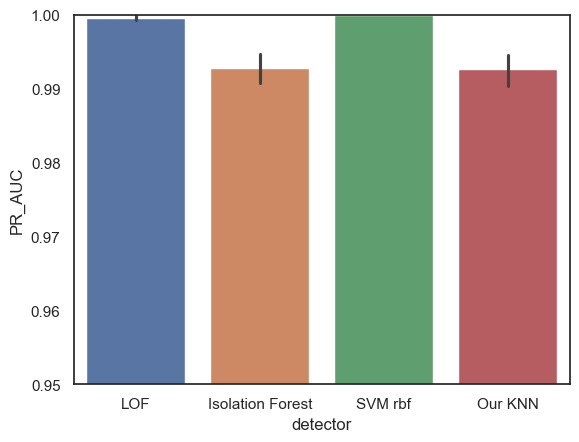

In [62]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="detector", y="PR_AUC", hue="detector")
ax.set_ylim(0.95, 1)
plt.show()

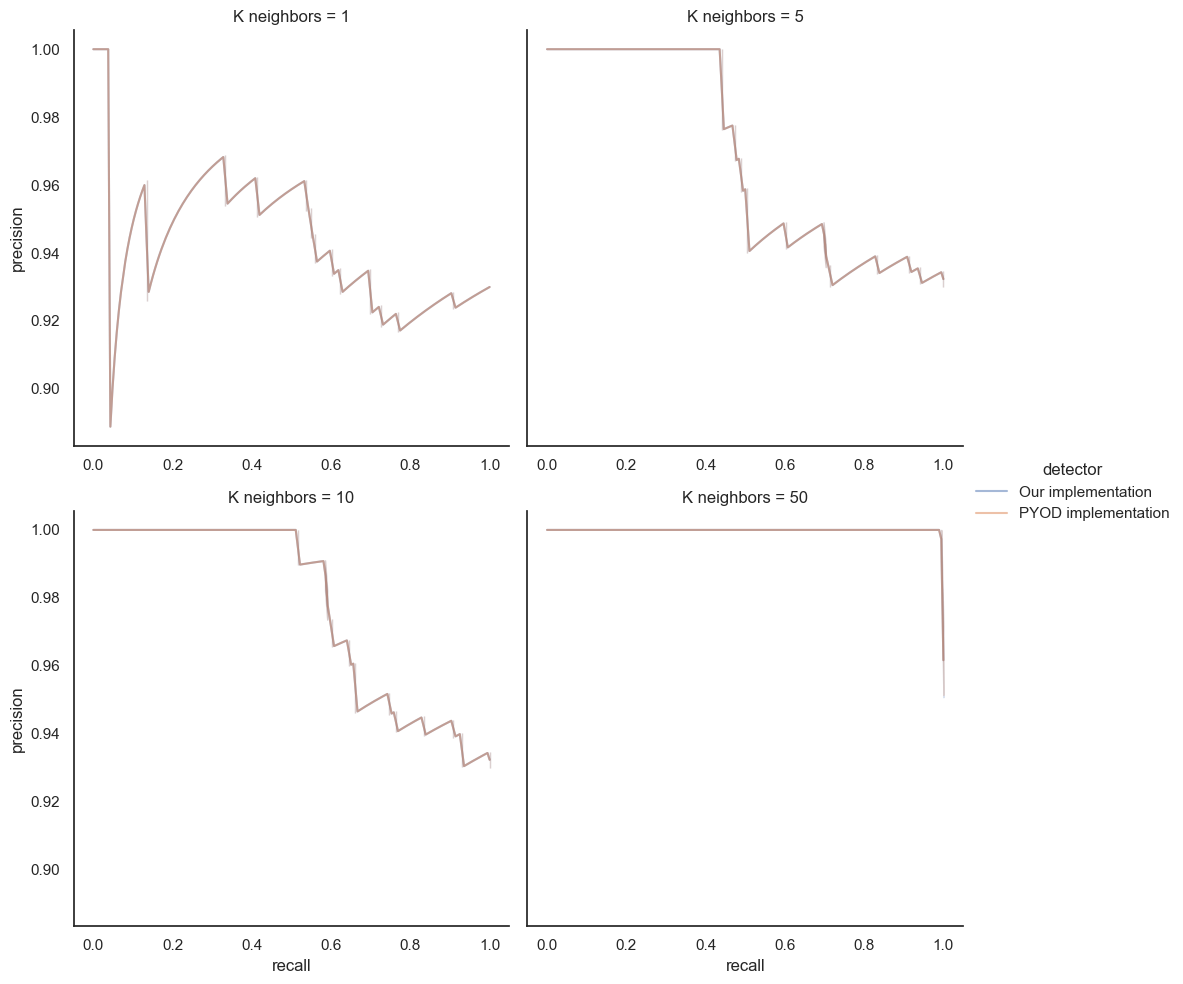

In [48]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="detector", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.5
)

### porownanie do innych algorytmow 

Dla zbioru "thyroid"

In [49]:
X = np.array(thyroid_features)
y = np.array(thyroid_labels)

In [50]:
detectors = [KNNAnomalyDetector(k=50), sklearn.neighbors.LocalOutlierFactor(n_neighbors=50, novelty=True), sklearn.ensemble.IsolationForest(), sklearn.svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)]
detector_names = ["LOF", "Isolation Forest", "SVM rbf", "Our KNN"]

In [51]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_arr = []
precision_arr = []
recall_arr = []
PR_AUC_arr = []
k_neighbors_arr = []
cv_arr = []
detector_arr = []

for n, detector in enumerate(detectors):
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        detector.fit(X_train)
        predictions = detector.predict(X_test)

        scores = detector.decision_function(X_test)
        if n == 0:
            precision, recall, _ = precision_recall_curve(y_test, -scores)
        else:
            precision, recall, _ = precision_recall_curve(y_test, scores)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, predictions, average='binary')

        f1_arr.append(f1)
        precision_arr.append(precision)
        recall_arr.append(recall)
        PR_AUC_arr.append(pr_auc)
        k_neighbors_arr.append(k)
        cv_arr.append(i)
        detector_arr.append(detector_names[n])
            
result_df = pd.DataFrame({"f1":f1_arr, "precision":precision_arr, "recall":recall_arr, 
                            "PR_AUC":PR_AUC_arr,  
                            "K neighbors":k_neighbors_arr, "CV":cv_arr, 
                            "detector": detector_arr})

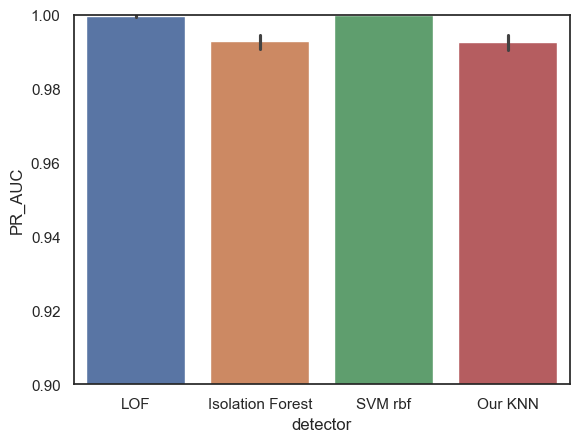

In [63]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="detector", y="PR_AUC", hue="detector")
ax.set_ylim(0.9, 1)
plt.show()

<Axes: xlabel='recall', ylabel='precision'>

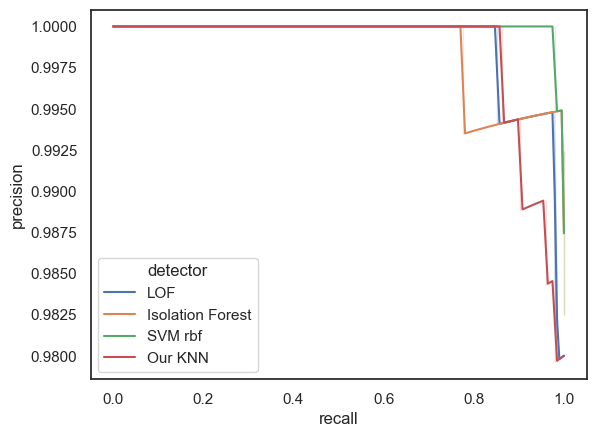

In [53]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
pr_df = pr_df.explode(['recall', 'precision'])

sns.lineplot(data=pr_df, x="recall", y="precision", hue="detector")

Dla zbioru "shuttle"

In [54]:
X = np.array(shuttle_features)
y = np.array(shuttle_labels)

In [55]:
detectors = [KNNAnomalyDetector(k=50), sklearn.neighbors.LocalOutlierFactor(n_neighbors=50, novelty=True), sklearn.ensemble.IsolationForest(), sklearn.svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)]
detector_names = ["LOF", "Isolation Forest", "SVM rbf", "Our KNN"]

In [56]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_arr = []
precision_arr = []
recall_arr = []
PR_AUC_arr = []
k_neighbors_arr = []
cv_arr = []
detector_arr = []

for n, detector in enumerate(detectors):
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        detector.fit(X_train)
        predictions = detector.predict(X_test)

        scores = detector.decision_function(X_test)
        if n == 0:
            precision, recall, _ = precision_recall_curve(y_test, -scores)
        else:
            precision, recall, _ = precision_recall_curve(y_test, scores)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, predictions, average='binary')

        f1_arr.append(f1)
        precision_arr.append(precision)
        recall_arr.append(recall)
        PR_AUC_arr.append(pr_auc)
        k_neighbors_arr.append(k)
        cv_arr.append(i)
        detector_arr.append(detector_names[n])
            
result_df = pd.DataFrame({"f1":f1_arr, "precision":precision_arr, "recall":recall_arr, 
                            "PR_AUC":PR_AUC_arr,  
                            "K neighbors":k_neighbors_arr, "CV":cv_arr, 
                            "detector": detector_arr})

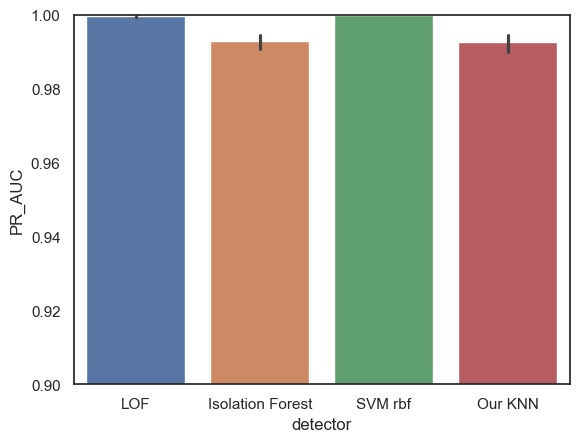

In [64]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="detector", y="PR_AUC", hue="detector")
ax.set_ylim(0.9, 1)
plt.show()

<Axes: xlabel='recall', ylabel='precision'>

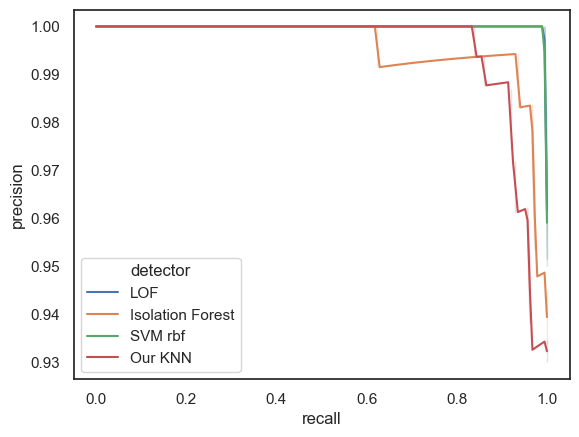

In [58]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
pr_df = pr_df.explode(['recall', 'precision'])

sns.lineplot(data=pr_df, x="recall", y="precision", hue="detector")